# SageMaker/DeepAR demo on Stores Daily Sales

In this lab, we will use Amazon SageMaker build-in algorithm DeepAR to forecast 1604 stores daily sales.

In particular, we will see how to:
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively
* Illustrate advanced features of DeepAR: additional time features and category information

Running this notebook takes around 40 min on a ml.c4.2xlarge for the training, and inference is done on a ml.m4.xlarge (the usage time will depend on how long you leave your served model running).

For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) or [paper](https://arxiv.org/abs/1704.04110), 

In [1]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

from decouple import config

In [2]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [4]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'tko-ts-workshop'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [5]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

Next, we configure the container image to be used for the region that we are running in.

In [6]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

### Import dataset and upload it to S3 to make it available for Sagemaker

We already has pre-processed the data we will use, it is under the same folder.

In [7]:
FILE_NAME = 'data/timeseries_raw.csv'

Then, we load and parse the dataset and convert it to a collection of Pandas time series, which makes common time series operations such as indexing by time periods or resampling much easier. The data has been processed, and the frequency is 1 day.

In [8]:
data = pd.read_csv(FILE_NAME, sep=",", index_col=0, parse_dates=True, decimal=',')
data.index = pd.DatetimeIndex(data.index,freq="1D")

num_timeseries = data.shape[1]

timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data.iloc[:,i], trim='f').astype(float))

Let us plot the resulting time series for the first ten stores.

In [9]:
# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = config('DATETIME_START_OF_TRAIN')
DATETIME_END_OF_TRAIN = config('DATETIME_END_OF_TRAIN')
DATETIME_START_OF_TEST = config('DATETIME_START_OF_TEST')
DATETIME_END_OF_TEST = config('DATETIME_END_OF_TEST')
DATETIME_START_OF_PREDICT = config('DATETIME_START_OF_PREDICT')
DATETIME_END_OF_PREDICT = config('DATETIME_END_OF_PREDICT')

# we use 1 day frequency for the time series
freq = config('freq')

# we predict for 7 days
prediction_length = config('prediction_length', cast=int)

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = config('context_length', cast=int)

sample_sites = config('sample_sites', cast=lambda v: [int(s.strip()) for s in v.split(',')])

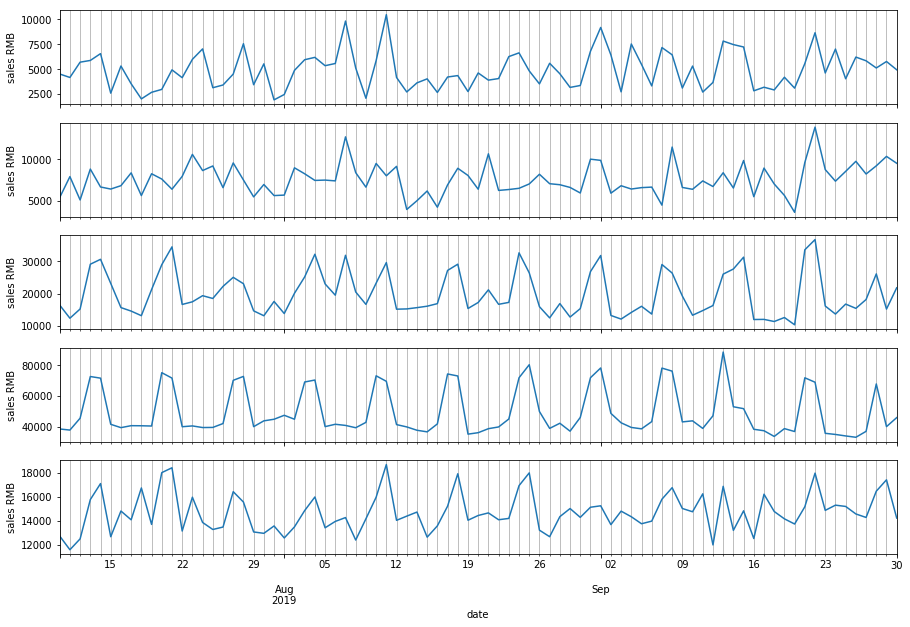

In [10]:
fig, axs = plt.subplots(len(sample_sites), 1, figsize=(15, 10), sharex=True)
axx = axs.ravel()
for i, site in enumerate(sample_sites):
    timeseries[site].loc[DATETIME_START_OF_TRAIN:DATETIME_END_OF_PREDICT].astype(float).plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("sales RMB")   
    axx[i].grid(which='minor', axis='x')

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

We specify here the portion of the data that is used for training: the model sees data from 2019-07-10 to 2019-09-16 for training.

In [11]:
start_dataset = pd.Timestamp(DATETIME_START_OF_TRAIN, freq=freq)
end_training = pd.Timestamp(DATETIME_END_OF_TRAIN, freq=freq)
end_test = pd.Timestamp(DATETIME_END_OF_TEST, freq=freq)
start_predict = pd.Timestamp(DATETIME_START_OF_PREDICT, freq=freq)
end_predict = pd.Timestamp(DATETIME_END_OF_PREDICT, freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [12]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

1604


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.

In [13]:
end_test

Timestamp('2019-09-24 00:00:00', freq='D')

In [14]:
test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_test - 1].tolist()
    }
    for ts in timeseries
]
print(len(test_data))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


1604


Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [15]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [16]:
%%time
write_dicts_to_file("data/train.json", training_data)
write_dicts_to_file("data/test.json", test_data)

CPU times: user 72.4 ms, sys: 8.04 ms, total: 80.5 ms
Wall time: 79.8 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes.

In [17]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [18]:
%%time
copy_to_s3("data/train.json", s3_data_path + "/train/train.json")
copy_to_s3("data/test.json", s3_data_path + "/test/test.json")

File s3://sagemaker-us-west-2-169088282855/s3://sagemaker-us-west-2-169088282855/tko-ts-workshop/data/train/train.json already exists.
Set override to upload anyway.

File s3://sagemaker-us-west-2-169088282855/s3://sagemaker-us-west-2-169088282855/tko-ts-workshop/data/test/test.json already exists.
Set override to upload anyway.

CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 88.5 ms


Let's have a look to what we just wrote to S3.

In [19]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2019-07-10 00:00:00", "target": ["14.0", "18.0", "22.4", "28.5", "25.0", "7.3", "31.1", "...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [20]:
sagemaker_session = sagemaker.Session()
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-stores-sales-demo',
    output_path=s3_output_path
)

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [21]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "32",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [22]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [23]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

2020-01-14 05:35:48 Starting - Starting the training job...
2020-01-14 05:35:50 Starting - Launching requested ML instances.........
2020-01-14 05:37:21 Starting - Preparing the instances for training...
2020-01-14 05:38:08 Downloading - Downloading input data
2020-01-14 05:38:08 Training - Downloading the training image..Arguments: train
[01/14/2020 05:38:32 INFO 139961373484864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/14/2020 05:38:32 I


2020-01-14 05:38:30 Training - Training image download completed. Training in progress.[01/14/2020 05:38:35 INFO 139961373484864] Epoch[1] Batch[5] avg_epoch_loss=8.628184
[01/14/2020 05:38:35 INFO 139961373484864] #quality_metric: host=algo-1, epoch=1, batch=5 train loss <loss>=8.62818400065
[01/14/2020 05:38:35 INFO 139961373484864] Epoch[1] Batch [5]#011Speed: 1972.26 samples/sec#011loss=8.628184
[01/14/2020 05:38:35 INFO 139961373484864] Epoch[1] Batch[10] avg_epoch_loss=8.713201
[01/14/2020 05:38:35 INFO 139961373484864] #quality_metric: host=algo-1, epoch=1, batch=10 train loss <loss>=8.81522140503
[01/14/2020 05:38:35 INFO 139961373484864] Epoch[1] Batch [10]#011Speed: 924.96 samples/sec#011loss=8.815221
[01/14/2020 05:38:35 INFO 139961373484864] Epoch[1] Batch[15] avg_epoch_loss=8.789337
[01/14/2020 05:38:35 INFO 139961373484864] #quality_metric: host=algo-1, epoch=1, batch=15 train loss <loss>=8.9568365097
[01/14/2020 05:38:35 INFO 139961373484864] Epoch[1] Batch [15]#011Spee

[01/14/2020 05:38:45 INFO 139961373484864] Epoch[8] Batch[20] avg_epoch_loss=8.474801
[01/14/2020 05:38:45 INFO 139961373484864] #quality_metric: host=algo-1, epoch=8, batch=20 train loss <loss>=8.33630886078
[01/14/2020 05:38:45 INFO 139961373484864] Epoch[8] Batch [20]#011Speed: 831.03 samples/sec#011loss=8.336309
[01/14/2020 05:38:45 INFO 139961373484864] Epoch[8] Batch[25] avg_epoch_loss=8.411400
[01/14/2020 05:38:45 INFO 139961373484864] #quality_metric: host=algo-1, epoch=8, batch=25 train loss <loss>=8.14511957169
[01/14/2020 05:38:45 INFO 139961373484864] Epoch[8] Batch [25]#011Speed: 1688.90 samples/sec#011loss=8.145120
[01/14/2020 05:38:45 INFO 139961373484864] Epoch[8] Batch[30] avg_epoch_loss=8.331514
[01/14/2020 05:38:45 INFO 139961373484864] #quality_metric: host=algo-1, epoch=8, batch=30 train loss <loss>=7.91610498428
[01/14/2020 05:38:45 INFO 139961373484864] Epoch[8] Batch [30]#011Speed: 805.52 samples/sec#011loss=7.916105
[01/14/2020 05:38:45 INFO 139961373484864] Ep

[01/14/2020 05:38:55 INFO 139961373484864] Epoch[15] Batch[40] avg_epoch_loss=8.191948
[01/14/2020 05:38:55 INFO 139961373484864] #quality_metric: host=algo-1, epoch=15, batch=40 train loss <loss>=7.94439582825
[01/14/2020 05:38:55 INFO 139961373484864] Epoch[15] Batch [40]#011Speed: 834.54 samples/sec#011loss=7.944396
[01/14/2020 05:38:55 INFO 139961373484864] Epoch[15] Batch[45] avg_epoch_loss=8.240902
[01/14/2020 05:38:55 INFO 139961373484864] #quality_metric: host=algo-1, epoch=15, batch=45 train loss <loss>=8.64231967926
[01/14/2020 05:38:55 INFO 139961373484864] Epoch[15] Batch [45]#011Speed: 2059.71 samples/sec#011loss=8.642320
[01/14/2020 05:38:55 INFO 139961373484864] processed a total of 1544 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1282.6869487762451, "sum": 1282.6869487762451, "min": 1282.6869487762451}}, "EndTime": 1578980335.650516, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578980334.367403

[01/14/2020 05:39:05 INFO 139961373484864] Epoch[23] Batch[15] avg_epoch_loss=8.389698
[01/14/2020 05:39:05 INFO 139961373484864] #quality_metric: host=algo-1, epoch=23, batch=15 train loss <loss>=8.40719947815
[01/14/2020 05:39:05 INFO 139961373484864] Epoch[23] Batch [15]#011Speed: 1482.68 samples/sec#011loss=8.407199
[01/14/2020 05:39:05 INFO 139961373484864] Epoch[23] Batch[20] avg_epoch_loss=8.421700
[01/14/2020 05:39:05 INFO 139961373484864] #quality_metric: host=algo-1, epoch=23, batch=20 train loss <loss>=8.52410526276
[01/14/2020 05:39:05 INFO 139961373484864] Epoch[23] Batch [20]#011Speed: 840.19 samples/sec#011loss=8.524105
[01/14/2020 05:39:05 INFO 139961373484864] Epoch[23] Batch[25] avg_epoch_loss=8.381641
[01/14/2020 05:39:05 INFO 139961373484864] #quality_metric: host=algo-1, epoch=23, batch=25 train loss <loss>=8.21339550018
[01/14/2020 05:39:05 INFO 139961373484864] Epoch[23] Batch [25]#011Speed: 1877.01 samples/sec#011loss=8.213396
[01/14/2020 05:39:05 INFO 139961373

[01/14/2020 05:39:15 INFO 139961373484864] Epoch[30] Batch[40] avg_epoch_loss=8.098229
[01/14/2020 05:39:15 INFO 139961373484864] #quality_metric: host=algo-1, epoch=30, batch=40 train loss <loss>=7.90504608154
[01/14/2020 05:39:15 INFO 139961373484864] Epoch[30] Batch [40]#011Speed: 1059.48 samples/sec#011loss=7.905046
[01/14/2020 05:39:15 INFO 139961373484864] Epoch[30] Batch[45] avg_epoch_loss=8.086116
[01/14/2020 05:39:15 INFO 139961373484864] #quality_metric: host=algo-1, epoch=30, batch=45 train loss <loss>=7.98679704666
[01/14/2020 05:39:15 INFO 139961373484864] Epoch[30] Batch [45]#011Speed: 2053.18 samples/sec#011loss=7.986797
[01/14/2020 05:39:15 INFO 139961373484864] Epoch[30] Batch[50] avg_epoch_loss=8.037830
[01/14/2020 05:39:15 INFO 139961373484864] #quality_metric: host=algo-1, epoch=30, batch=50 train loss <loss>=7.59359769821
[01/14/2020 05:39:15 INFO 139961373484864] Epoch[30] Batch [50]#011Speed: 1342.31 samples/sec#011loss=7.593598
[01/14/2020 05:39:15 INFO 13996137

[01/14/2020 05:39:25 INFO 139961373484864] Epoch[38] Batch[20] avg_epoch_loss=8.359054
[01/14/2020 05:39:25 INFO 139961373484864] #quality_metric: host=algo-1, epoch=38, batch=20 train loss <loss>=8.30429134369
[01/14/2020 05:39:25 INFO 139961373484864] Epoch[38] Batch [20]#011Speed: 962.44 samples/sec#011loss=8.304291
[01/14/2020 05:39:25 INFO 139961373484864] Epoch[38] Batch[25] avg_epoch_loss=8.287215
[01/14/2020 05:39:25 INFO 139961373484864] #quality_metric: host=algo-1, epoch=38, batch=25 train loss <loss>=7.98549165726
[01/14/2020 05:39:25 INFO 139961373484864] Epoch[38] Batch [25]#011Speed: 2079.87 samples/sec#011loss=7.985492
[01/14/2020 05:39:25 INFO 139961373484864] Epoch[38] Batch[30] avg_epoch_loss=8.185175
[01/14/2020 05:39:25 INFO 139961373484864] #quality_metric: host=algo-1, epoch=38, batch=30 train loss <loss>=7.65456762314
[01/14/2020 05:39:25 INFO 139961373484864] Epoch[38] Batch [30]#011Speed: 872.73 samples/sec#011loss=7.654568
[01/14/2020 05:39:25 INFO 1399613734

[01/14/2020 05:39:35 INFO 139961373484864] Epoch[45] Batch[50] avg_epoch_loss=8.140322
[01/14/2020 05:39:35 INFO 139961373484864] #quality_metric: host=algo-1, epoch=45, batch=50 train loss <loss>=8.79283571243
[01/14/2020 05:39:35 INFO 139961373484864] Epoch[45] Batch [50]#011Speed: 1263.74 samples/sec#011loss=8.792836
[01/14/2020 05:39:35 INFO 139961373484864] processed a total of 1604 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1353.3430099487305, "sum": 1353.3430099487305, "min": 1353.3430099487305}}, "EndTime": 1578980375.608816, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578980374.255202}

[01/14/2020 05:39:35 INFO 139961373484864] #throughput_metric: host=algo-1, train throughput=1185.11778683 records/second
[01/14/2020 05:39:35 INFO 139961373484864] #progress_metric: host=algo-1, completed 11 % of epochs
[01/14/2020 05:39:35 INFO 139961373484864] #quality_metric: host=algo-1, epoch=45, train loss <lo

[01/14/2020 05:39:45 INFO 139961373484864] Epoch[53] Batch[30] avg_epoch_loss=8.133182
[01/14/2020 05:39:45 INFO 139961373484864] #quality_metric: host=algo-1, epoch=53, batch=30 train loss <loss>=7.70223007202
[01/14/2020 05:39:45 INFO 139961373484864] Epoch[53] Batch [30]#011Speed: 954.07 samples/sec#011loss=7.702230
[01/14/2020 05:39:45 INFO 139961373484864] Epoch[53] Batch[35] avg_epoch_loss=8.071344
[01/14/2020 05:39:45 INFO 139961373484864] #quality_metric: host=algo-1, epoch=53, batch=35 train loss <loss>=7.68795223236
[01/14/2020 05:39:45 INFO 139961373484864] Epoch[53] Batch [35]#011Speed: 2147.10 samples/sec#011loss=7.687952
[01/14/2020 05:39:45 INFO 139961373484864] Epoch[53] Batch[40] avg_epoch_loss=8.078876
[01/14/2020 05:39:45 INFO 139961373484864] #quality_metric: host=algo-1, epoch=53, batch=40 train loss <loss>=8.13310585022
[01/14/2020 05:39:45 INFO 139961373484864] Epoch[53] Batch [40]#011Speed: 949.11 samples/sec#011loss=8.133106
[01/14/2020 05:39:45 INFO 1399613734

[01/14/2020 05:39:55 INFO 139961373484864] Epoch[61] Batch[10] avg_epoch_loss=8.250242
[01/14/2020 05:39:55 INFO 139961373484864] #quality_metric: host=algo-1, epoch=61, batch=10 train loss <loss>=8.38029994965
[01/14/2020 05:39:55 INFO 139961373484864] Epoch[61] Batch [10]#011Speed: 859.97 samples/sec#011loss=8.380300
[01/14/2020 05:39:55 INFO 139961373484864] Epoch[61] Batch[15] avg_epoch_loss=8.391806
[01/14/2020 05:39:55 INFO 139961373484864] #quality_metric: host=algo-1, epoch=61, batch=15 train loss <loss>=8.70324687958
[01/14/2020 05:39:55 INFO 139961373484864] Epoch[61] Batch [15]#011Speed: 2133.45 samples/sec#011loss=8.703247
[01/14/2020 05:39:55 INFO 139961373484864] Epoch[61] Batch[20] avg_epoch_loss=8.314138
[01/14/2020 05:39:55 INFO 139961373484864] #quality_metric: host=algo-1, epoch=61, batch=20 train loss <loss>=8.06560125351
[01/14/2020 05:39:55 INFO 139961373484864] Epoch[61] Batch [20]#011Speed: 992.55 samples/sec#011loss=8.065601
[01/14/2020 05:39:55 INFO 1399613734

[01/14/2020 05:40:05 INFO 139961373484864] Epoch[68] Batch[30] avg_epoch_loss=8.204748
[01/14/2020 05:40:05 INFO 139961373484864] #quality_metric: host=algo-1, epoch=68, batch=30 train loss <loss>=7.65424003601
[01/14/2020 05:40:05 INFO 139961373484864] Epoch[68] Batch [30]#011Speed: 936.25 samples/sec#011loss=7.654240
[01/14/2020 05:40:05 INFO 139961373484864] Epoch[68] Batch[35] avg_epoch_loss=8.155117
[01/14/2020 05:40:05 INFO 139961373484864] #quality_metric: host=algo-1, epoch=68, batch=35 train loss <loss>=7.84739980698
[01/14/2020 05:40:05 INFO 139961373484864] Epoch[68] Batch [35]#011Speed: 1744.14 samples/sec#011loss=7.847400
[01/14/2020 05:40:05 INFO 139961373484864] Epoch[68] Batch[40] avg_epoch_loss=8.112273
[01/14/2020 05:40:05 INFO 139961373484864] #quality_metric: host=algo-1, epoch=68, batch=40 train loss <loss>=7.80380144119
[01/14/2020 05:40:05 INFO 139961373484864] Epoch[68] Batch [40]#011Speed: 889.99 samples/sec#011loss=7.803801
[01/14/2020 05:40:05 INFO 1399613734

[01/14/2020 05:40:16 INFO 139961373484864] Number of test batches scored: 20
[01/14/2020 05:40:18 INFO 139961373484864] Number of test batches scored: 30
[01/14/2020 05:40:20 INFO 139961373484864] Number of test batches scored: 40
[01/14/2020 05:40:23 INFO 139961373484864] Number of test batches scored: 50
[01/14/2020 05:40:25 INFO 139961373484864] Number of test batches scored: 60
[01/14/2020 05:40:27 INFO 139961373484864] Number of test batches scored: 70
[01/14/2020 05:40:30 INFO 139961373484864] Number of test batches scored: 80
[01/14/2020 05:40:32 INFO 139961373484864] Number of test batches scored: 90

2020-01-14 05:40:43 Uploading - Uploading generated training model
2020-01-14 05:40:43 Completed - Training job completed
[01/14/2020 05:40:34 INFO 139961373484864] Number of test batches scored: 100
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 23676.774978637695, "sum": 23676.774978637695, "min": 23676.774978637695}}, "EndTime": 1578980435.069537, "Dimensions": {

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [24]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [25]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

--------------------------------------------------------------------------------------------------!

### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

In [26]:
predictor.predict(ts=timeseries[0][start_dataset:end_test-1],quantiles=[0.10, 0.5, 0.90])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2019-09-24,-36.638447,67.680878,13.883380
2019-09-25,-27.640455,53.424389,5.218937
2019-09-26,-33.648399,45.437904,10.477715
2019-09-27,-25.318699,51.619938,13.713567
2019-09-28,-17.961573,65.252762,19.514605
2019-09-29,-25.567118,64.970306,16.786739
2019-09-30,-18.457382,55.730263,17.439478


Below we define a plotting function that queries the model and displays the forecast.

In [27]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 12))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [28]:
style = {'description_width': 'initial'}

In [29]:
plt.figure(figsize=(15,5))
@interact_manual(
    customer_id=IntSlider(min=0, max=1603, value=120, style=style), 
#     forecast_day= prediction_length,
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_days_plot=IntSlider(min=1, max=50, value=7, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, confidence, history_days_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[customer_id],
        forecast_date= start_predict -1,#end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_days_plot,
        confidence=confidence
    )

<Figure size 1080x360 with 0 Axes>

interactive(children=(IntSlider(value=120, description='customer_id', max=1603, style=SliderStyle(description_…

## Check metrics

In [30]:
%%time

preds = []
quantiles=[0.10, 0.5, 0.90]

for i, ts_dict in enumerate(timeseries):
    ts = ts_dict[start_dataset:end_test-1]
    if ts.shape[0] == 0:
        preds.append(None)
        continue
    pred = predictor.predict(ts=ts, quantiles=quantiles)
    preds.append(pred)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


CPU times: user 4.84 s, sys: 66.8 ms, total: 4.9 s
Wall time: 44.9 s


In [31]:
# Write predict result and label data into a csv for later use
df = pd.DataFrame()
for i in range(len(timeseries)):
    y =  timeseries[i][start_predict:end_predict].fillna(0)
    y_hat = preds[i]['0.5']
    dd = pd.DataFrame({'store_id':i,'y_label': y, 'y_pred': y_hat})
    df = pd.concat([df, dd])
df.index.name='date'
df.to_csv("data/deepar-predict-result.csv")

Print sample site stores prediction result, you can print more if you want.

i: 24
RMSE: 1545.5128864862834
MAE: 1313.3492187499999
Target Mean: 5569.585714285714
                 y_pred  y_label
2019-09-24  4326.017090   7026.0
2019-09-25  4259.150391   4043.6
2019-09-26  4485.296875   6221.2
2019-09-27  4948.722656   5847.8
2019-09-28  6893.340820   5126.7
2019-09-29  7297.247070   5775.6
2019-09-30  4591.557129   4946.2


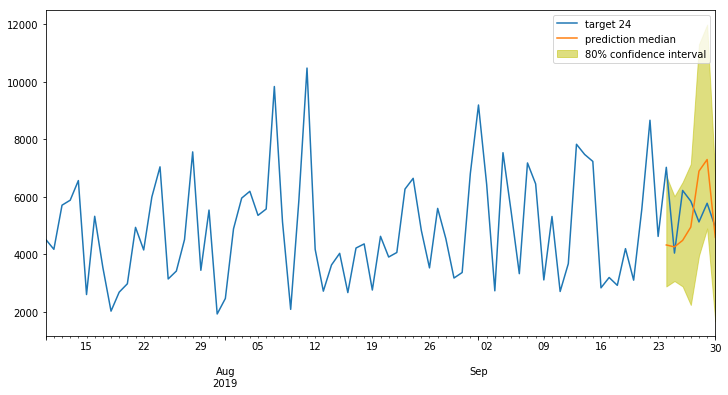

i: 31
RMSE: 1431.5780657293394
MAE: 1320.739941406257
Target Mean: 9007.67142857143
                  y_pred  y_label
2019-09-24   8450.292969   7383.9
2019-09-25   7609.324219   8558.8
2019-09-26   7416.754395   9763.9
2019-09-27   6581.782715   8243.4
2019-09-28   8008.385254   9221.3
2019-09-29  10831.983398  10352.9
2019-09-30   8000.950195   9529.5


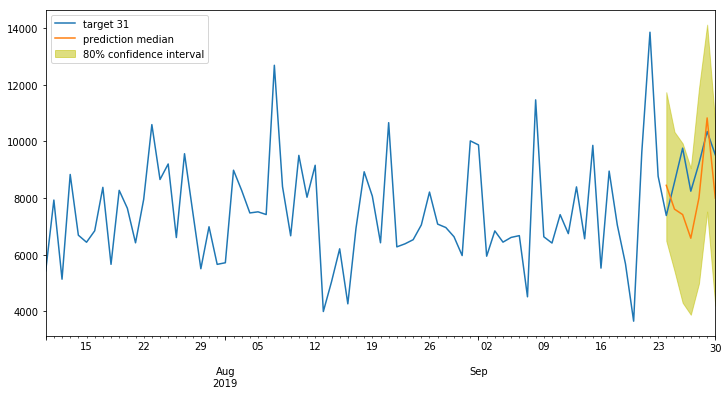

i: 36
RMSE: 6129.976181292475
MAE: 3756.5088169642863
Target Mean: 18153.442857142858
                  y_pred  y_label
2019-09-24  14742.213867  13646.5
2019-09-25  14906.513672  16744.0
2019-09-26  15506.921875  15419.9
2019-09-27  17067.605469  18162.3
2019-09-28  27227.589844  26111.2
2019-09-29  29853.958984  15189.3
2019-09-30  15401.303711  21800.9


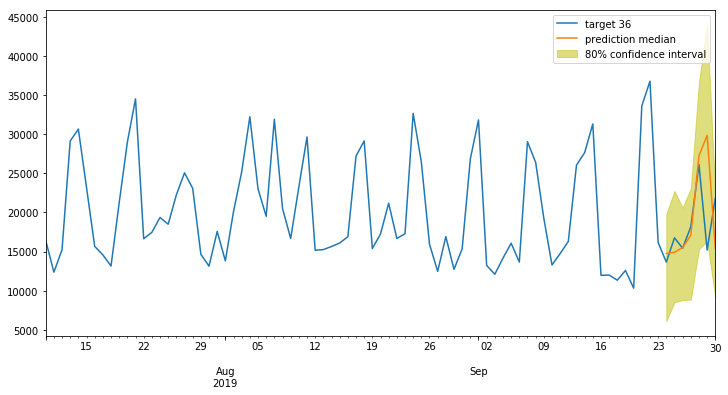

i: 87
RMSE: 14765.199948910147
MAE: 11483.541361607144
Target Mean: 41728.84428571429
                  y_pred   y_label
2019-09-24  43544.359375  34817.70
2019-09-25  42075.957031  33837.11
2019-09-26  43286.269531  32969.10
2019-09-27  56028.570312  36843.10
2019-09-28  71051.937500  67866.62
2019-09-29  69883.562500  39937.69
2019-09-30  45045.136719  45830.59


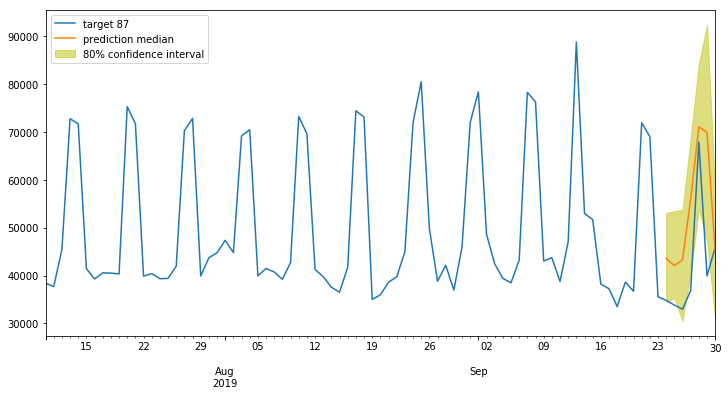

i: 997
RMSE: 1057.7972407393052
MAE: 918.5573325892856
Target Mean: 15377.522857142858
                  y_pred   y_label
2019-09-24  15721.121094  15329.22
2019-09-25  15929.296875  15222.59
2019-09-26  15406.009766  14596.20
2019-09-27  15612.500000  14304.67
2019-09-28  16072.645508  16493.07
2019-09-29  16650.335938  17440.53
2019-09-30  16259.415039  14256.38


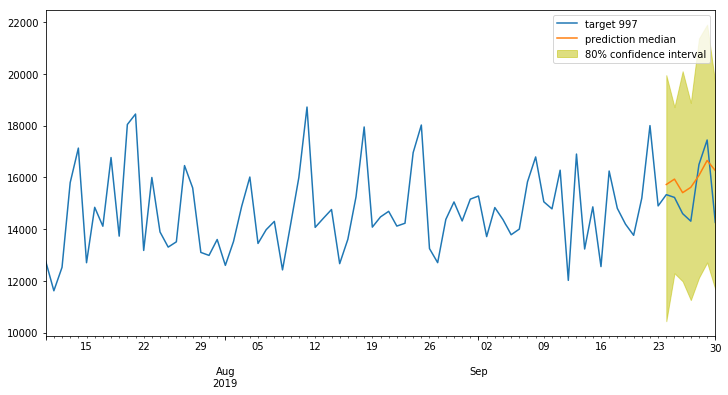

CPU times: user 2.6 s, sys: 83.3 ms, total: 2.68 s
Wall time: 3.11 s


In [32]:
%%time
from sklearn import metrics

def show_metrics(sample_sites, pred_result, target_quantile='0.5'):
    preds = pred_result
    for i in sample_sites:  # TODO len(timeseries)
        if preds[i] is None:
            continue
        
        s = timeseries[i].fillna(0)
        
        print("i:", i)
        p10 = preds[i]['0.1']
        p90 = preds[i]['0.9']
        y_label =  timeseries[i][start_predict:end_predict].fillna(0)
        y_pred = preds[i][target_quantile]
        if y_label.shape[0] != y_pred.shape[0]:
            continue
        
        print("RMSE:",np.sqrt(metrics.mean_squared_error(y_label, y_pred)))
        print("MAE:",metrics.mean_absolute_error(y_label, y_pred))
        print("Target Mean:",y_label.mean())
        print(pd.DataFrame({'y_pred': y_pred, 'y_label': y_label}))
        plt.figure(figsize=(12,6))
        s.plot(label='target %s'%str(i))
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        y_pred.plot(label='prediction median')
        plt.legend()
        plt.show()

show_metrics(sample_sites, preds, target_quantile='0.5')

# Additional features

We have seen how to prepare a dataset and run DeepAR for a simple example.

In addition DeepAR supports the following features:

* missing values: DeepAR can handle missing values in the time series during training as well as for inference.
* Additional time features: DeepAR provides a set default time series features such as hour of day etc. However, you can provide additional feature time series via the `dynamic_feat` field. 
* generalize frequencies: any integer multiple of the previously supported base frequencies (minutes `min`, hours `H`, days `D`, weeks `W`, month `M`) are now allowed; e.g., `15min`. We already demonstrated this above by using `1D` frequency.
* categories: If your time series belong to different groups (e.g. types of product, regions, etc), this information can be encoded as one or more categorical features using the `cat` field.

We will now demonstrate categories and time features support. For this part we will reuse the stores sales dataset, we get categories of the stores from data owner and crawler weather data from http://lishi.tianqi.com/shenzhen as dynamic time series: 
* weather time series will contain: the high temperature, the low temperature of the day, whether is rainy, whether is sunshine, whether is cloudy;
* besides that, we add addtional time series that whether the day is weekend;
* categories: 1D array for each target series;

dynamic_feat: total 6 dynamic_feat, the high temperature, the low temperature, is_sunshine, is_rain, is_cloudy, is_weekend. As the stores are in the same city, so each store time series will use same dynamic_feat values.

## Prepare dataset

We will read those data as we have prepared in advance. 

cat is stand for category, here it is a one 1d vector for each store time series.

In [33]:
cat = pd.read_csv('data/cat.csv', sep=",", index_col=0, parse_dates=True)
cat_num_timeseries = cat.shape[0]
cat_timeseries = []
for i in range(cat_num_timeseries):
    cat_timeseries.append(cat.loc[i])

In [34]:
is_weekend = pd.read_csv('data/is_weekend.csv', sep=",", index_col=0, parse_dates=True)
is_weekend_timeseries = is_weekend.iloc[:,0]
is_weekend_timeseries

date
2019-07-10    0
2019-07-11    0
2019-07-12    0
2019-07-13    1
2019-07-14    1
2019-07-15    0
2019-07-16    0
2019-07-17    0
2019-07-18    0
2019-07-19    0
2019-07-20    1
2019-07-21    1
2019-07-22    0
2019-07-23    0
2019-07-24    0
2019-07-25    0
2019-07-26    0
2019-07-27    1
2019-07-28    1
2019-07-29    0
2019-07-30    0
2019-07-31    0
2019-08-01    0
2019-08-02    0
2019-08-03    1
2019-08-04    1
2019-08-05    0
2019-08-06    0
2019-08-07    0
2019-08-08    0
             ..
2019-09-01    1
2019-09-02    0
2019-09-03    0
2019-09-04    0
2019-09-05    0
2019-09-06    0
2019-09-07    1
2019-09-08    1
2019-09-09    0
2019-09-10    0
2019-09-11    0
2019-09-12    0
2019-09-13    0
2019-09-14    1
2019-09-15    1
2019-09-16    0
2019-09-17    0
2019-09-18    0
2019-09-19    0
2019-09-20    0
2019-09-21    1
2019-09-22    1
2019-09-23    0
2019-09-24    0
2019-09-25    0
2019-09-26    0
2019-09-27    0
2019-09-28    1
2019-09-29    1
2019-09-30    0
Name: is_weekend, L

In [35]:
weather = pd.read_csv('data/shenzhen_weather.csv', sep=",", index_col=0, parse_dates=True)
w_num_timeseries = weather.shape[1]
w_timeseries = []
for i in range(w_num_timeseries):
    w_timeseries.append(weather.iloc[:,i])

In [36]:
train_dynamic_feat= []
for i in range(5):
    train_dynamic_feat.append(w_timeseries[i][start_dataset:end_training -1].tolist())
train_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_training -1].tolist())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


In [37]:
test_dynamic_feat= []
for i in range(5):
    test_dynamic_feat.append(w_timeseries[i][start_dataset:end_test -1].tolist())
test_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_test -1].tolist())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


In [38]:
predict_dynamic_feat= []
for i in range(5):
    predict_dynamic_feat.append(w_timeseries[i][start_dataset:end_predict -1].tolist())
predict_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_predict -1].tolist())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


The DeepAR JSON input format represents each time series as a JSON object. In the case each time series consists of a start time stamp (``start``) and a list of values (``target``)as well as ``dynamic_feat`` for time-series features and ``cat`` for categorical features.

In [39]:
%%time

training_data_new_features = [
    {
        "start": str(start_dataset),
        "target": timeseries[i][start_dataset:end_training -1].tolist(),
        "cat": cat_timeseries[i].tolist(),
        "dynamic_feat": train_dynamic_feat
    }
    for i in range(cat_num_timeseries)
]
print(len(training_data_new_features))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


1604
CPU times: user 420 ms, sys: 63 µs, total: 420 ms
Wall time: 419 ms


In [40]:
test_data_new_features = [
    {
        "start": str(start_dataset),
        "target": timeseries[i][start_dataset:end_test -1].tolist(),
        "cat": cat_timeseries[i].tolist(),
        "dynamic_feat": test_dynamic_feat
    }
    for i in range(cat_num_timeseries)
]
print(len(test_data_new_features))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


1604


In [41]:
def check_dataset_consistency(train_dataset, test_dataset=None):
    d = train_dataset[0]
    has_dynamic_feat = 'dynamic_feat' in d
    if has_dynamic_feat:
        num_dynamic_feat = len(d['dynamic_feat'])
    has_cat = 'cat' in d
    if has_cat:
        num_cat = len(d['cat'])
    
    def check_ds(ds):
        for i, d in enumerate(ds):
            if has_dynamic_feat:
                assert 'dynamic_feat' in d
                assert num_dynamic_feat == len(d['dynamic_feat'])
                for f in d['dynamic_feat']:
                    assert len(d['target']) == len(f)
                    
            if has_cat:
                assert 'cat' in d
                assert len(d['cat']) == num_cat
    check_ds(train_dataset)
    if test_dataset is not None:
        
        check_ds(test_dataset)
        
check_dataset_consistency(training_data_new_features, test_data_new_features)

Write the new train and test data to local disk.

In [42]:
%%time
write_dicts_to_file("data/train_new_features.json", training_data_new_features)
write_dicts_to_file("data/test_new_features.json", test_data_new_features)

CPU times: user 214 ms, sys: 3.96 ms, total: 218 ms
Wall time: 218 ms


Upload the new train and test data to S3 bucket, here we will use new bucket which has a extend name '-new-features' of the bucket name you used in before case.

In [43]:
%%time

s3_data_path_new_features = "s3://{}/{}-new-features/data".format(s3_bucket, s3_prefix)
s3_output_path_new_features = "s3://{}/{}-new-features/output".format(s3_bucket, s3_prefix)

print('Uploading to S3 this may take a few minutes depending on your connection.')
copy_to_s3("data/train_new_features.json", s3_data_path_new_features + "/train/train_new_features.json", override=True)
copy_to_s3("data/test_new_features.json", s3_data_path_new_features + "/test/test_new_features.json", override=True)

Uploading to S3 this may take a few minutes depending on your connection.
Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-169088282855/tko-ts-workshop-new-features/data/train/train_new_features.json
Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-169088282855/tko-ts-workshop-new-features/data/test/test_new_features.json
CPU times: user 36.8 ms, sys: 26.7 ms, total: 63.5 ms
Wall time: 354 ms


Agagin, let's setup the estimator and hyperparameters, then let's fit it.

In [44]:
%%time
estimator_new_features = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-stores-sales-demo',
    output_path=s3_output_path_new_features
)

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "epochs": "400",
    "learning_rate": "5E-4",
    "mini_batch_size": "32",
    "early_stopping_patience": "40",
    "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
}
estimator_new_features.set_hyperparameters(**hyperparameters)

estimator_new_features.fit(
    inputs={
        "train": "{}/train/".format(s3_data_path_new_features),
        "test": "{}/test/".format(s3_data_path_new_features)
    }, 
    wait=True
)

2020-01-14 05:58:12 Starting - Starting the training job...
2020-01-14 05:58:13 Starting - Launching requested ML instances......
2020-01-14 05:59:13 Starting - Preparing the instances for training...
2020-01-14 05:59:54 Downloading - Downloading input data...
2020-01-14 06:00:35 Training - Training image download completed. Training in progress.Arguments: train
[01/14/2020 06:00:37 INFO 140422162138944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''

[01/14/2020 06:00:49 INFO 140422162138944] Epoch[6] Batch[10] avg_epoch_loss=8.765116
[01/14/2020 06:00:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=6, batch=10 train loss <loss>=8.63787441254
[01/14/2020 06:00:49 INFO 140422162138944] Epoch[6] Batch [10]#011Speed: 740.83 samples/sec#011loss=8.637874
[01/14/2020 06:00:49 INFO 140422162138944] Epoch[6] Batch[15] avg_epoch_loss=8.740341
[01/14/2020 06:00:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=6, batch=15 train loss <loss>=8.68583698273
[01/14/2020 06:00:49 INFO 140422162138944] Epoch[6] Batch [15]#011Speed: 1259.44 samples/sec#011loss=8.685837
[01/14/2020 06:00:49 INFO 140422162138944] Epoch[6] Batch[20] avg_epoch_loss=8.716320
[01/14/2020 06:00:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=6, batch=20 train loss <loss>=8.639453125
[01/14/2020 06:00:49 INFO 140422162138944] Epoch[6] Batch [20]#011Speed: 788.07 samples/sec#011loss=8.639453
[01/14/2020 06:00:49 INFO 140422162138944] Epoc

[01/14/2020 06:00:59 INFO 140422162138944] Epoch[12] Batch[5] avg_epoch_loss=8.425347
[01/14/2020 06:00:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=8.42534701029
[01/14/2020 06:00:59 INFO 140422162138944] Epoch[12] Batch [5]#011Speed: 1610.58 samples/sec#011loss=8.425347
[01/14/2020 06:00:59 INFO 140422162138944] Epoch[12] Batch[10] avg_epoch_loss=8.538401
[01/14/2020 06:00:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=12, batch=10 train loss <loss>=8.67406539917
[01/14/2020 06:00:59 INFO 140422162138944] Epoch[12] Batch [10]#011Speed: 647.01 samples/sec#011loss=8.674065
[01/14/2020 06:00:59 INFO 140422162138944] Epoch[12] Batch[15] avg_epoch_loss=8.508998
[01/14/2020 06:00:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=12, batch=15 train loss <loss>=8.4443104744
[01/14/2020 06:00:59 INFO 140422162138944] Epoch[12] Batch [15]#011Speed: 1661.46 samples/sec#011loss=8.444310
[01/14/2020 06:01:00 INFO 1404221621389

[01/14/2020 06:01:09 INFO 140422162138944] Epoch[18] Batch[5] avg_epoch_loss=8.354700
[01/14/2020 06:01:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=18, batch=5 train loss <loss>=8.35470024745
[01/14/2020 06:01:09 INFO 140422162138944] Epoch[18] Batch [5]#011Speed: 1587.82 samples/sec#011loss=8.354700
[01/14/2020 06:01:09 INFO 140422162138944] Epoch[18] Batch[10] avg_epoch_loss=8.322463
[01/14/2020 06:01:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=18, batch=10 train loss <loss>=8.28377838135
[01/14/2020 06:01:09 INFO 140422162138944] Epoch[18] Batch [10]#011Speed: 777.41 samples/sec#011loss=8.283778
[01/14/2020 06:01:09 INFO 140422162138944] Epoch[18] Batch[15] avg_epoch_loss=8.400456
[01/14/2020 06:01:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=18, batch=15 train loss <loss>=8.57203979492
[01/14/2020 06:01:09 INFO 140422162138944] Epoch[18] Batch [15]#011Speed: 1554.76 samples/sec#011loss=8.572040
[01/14/2020 06:01:09 INFO 140422162138

[01/14/2020 06:01:19 INFO 140422162138944] Epoch[24] Batch[10] avg_epoch_loss=8.358650
[01/14/2020 06:01:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=24, batch=10 train loss <loss>=8.53752632141
[01/14/2020 06:01:19 INFO 140422162138944] Epoch[24] Batch [10]#011Speed: 722.37 samples/sec#011loss=8.537526
[01/14/2020 06:01:19 INFO 140422162138944] Epoch[24] Batch[15] avg_epoch_loss=8.408210
[01/14/2020 06:01:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=24, batch=15 train loss <loss>=8.5172410965
[01/14/2020 06:01:19 INFO 140422162138944] Epoch[24] Batch [15]#011Speed: 1513.38 samples/sec#011loss=8.517241
[01/14/2020 06:01:19 INFO 140422162138944] Epoch[24] Batch[20] avg_epoch_loss=8.350140
[01/14/2020 06:01:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=24, batch=20 train loss <loss>=8.16431732178
[01/14/2020 06:01:19 INFO 140422162138944] Epoch[24] Batch [20]#011Speed: 727.34 samples/sec#011loss=8.164317
[01/14/2020 06:01:19 INFO 14042216213

[01/14/2020 06:01:29 INFO 140422162138944] Epoch[30] Batch[5] avg_epoch_loss=8.190466
[01/14/2020 06:01:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=30, batch=5 train loss <loss>=8.19046552976
[01/14/2020 06:01:29 INFO 140422162138944] Epoch[30] Batch [5]#011Speed: 1518.81 samples/sec#011loss=8.190466
[01/14/2020 06:01:29 INFO 140422162138944] Epoch[30] Batch[10] avg_epoch_loss=8.135023
[01/14/2020 06:01:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=30, batch=10 train loss <loss>=8.06849212646
[01/14/2020 06:01:29 INFO 140422162138944] Epoch[30] Batch [10]#011Speed: 781.35 samples/sec#011loss=8.068492
[01/14/2020 06:01:29 INFO 140422162138944] Epoch[30] Batch[15] avg_epoch_loss=8.232800
[01/14/2020 06:01:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=30, batch=15 train loss <loss>=8.44790992737
[01/14/2020 06:01:29 INFO 140422162138944] Epoch[30] Batch [15]#011Speed: 1609.87 samples/sec#011loss=8.447910
[01/14/2020 06:01:30 INFO 140422162138

[01/14/2020 06:01:39 INFO 140422162138944] Epoch[36] Batch[0] avg_epoch_loss=8.880826
[01/14/2020 06:01:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=36, batch=0 train loss <loss>=8.8808259964
[01/14/2020 06:01:39 INFO 140422162138944] Epoch[36] Batch[5] avg_epoch_loss=8.238464
[01/14/2020 06:01:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=36, batch=5 train loss <loss>=8.238464276
[01/14/2020 06:01:39 INFO 140422162138944] Epoch[36] Batch [5]#011Speed: 1631.62 samples/sec#011loss=8.238464
[01/14/2020 06:01:39 INFO 140422162138944] Epoch[36] Batch[10] avg_epoch_loss=8.306951
[01/14/2020 06:01:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=36, batch=10 train loss <loss>=8.38913440704
[01/14/2020 06:01:39 INFO 140422162138944] Epoch[36] Batch [10]#011Speed: 809.29 samples/sec#011loss=8.389134
[01/14/2020 06:01:39 INFO 140422162138944] Epoch[36] Batch[15] avg_epoch_loss=8.337675
[01/14/2020 06:01:39 INFO 140422162138944] #quality_metric: host=al

[01/14/2020 06:01:49 INFO 140422162138944] Epoch[41] Batch[50] avg_epoch_loss=8.018682
[01/14/2020 06:01:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=41, batch=50 train loss <loss>=7.59585399628
[01/14/2020 06:01:49 INFO 140422162138944] Epoch[41] Batch [50]#011Speed: 1227.36 samples/sec#011loss=7.595854
[01/14/2020 06:01:49 INFO 140422162138944] processed a total of 1618 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1695.1000690460205, "sum": 1695.1000690460205, "min": 1695.1000690460205}}, "EndTime": 1578981709.544761, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578981707.84917}

[01/14/2020 06:01:49 INFO 140422162138944] #throughput_metric: host=algo-1, train throughput=954.443964046 records/second
[01/14/2020 06:01:49 INFO 140422162138944] #progress_metric: host=algo-1, completed 10 % of epochs
[01/14/2020 06:01:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=41, train loss <los

[01/14/2020 06:01:59 INFO 140422162138944] Epoch[47] Batch[40] avg_epoch_loss=8.110967
[01/14/2020 06:01:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=47, batch=40 train loss <loss>=7.62839593887
[01/14/2020 06:01:59 INFO 140422162138944] Epoch[47] Batch [40]#011Speed: 690.79 samples/sec#011loss=7.628396
[01/14/2020 06:01:59 INFO 140422162138944] Epoch[47] Batch[45] avg_epoch_loss=8.097082
[01/14/2020 06:01:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=47, batch=45 train loss <loss>=7.98322401047
[01/14/2020 06:01:59 INFO 140422162138944] Epoch[47] Batch [45]#011Speed: 1265.19 samples/sec#011loss=7.983224
[01/14/2020 06:01:59 INFO 140422162138944] Epoch[47] Batch[50] avg_epoch_loss=8.063995
[01/14/2020 06:01:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=47, batch=50 train loss <loss>=7.75960054398
[01/14/2020 06:01:59 INFO 140422162138944] Epoch[47] Batch [50]#011Speed: 1065.81 samples/sec#011loss=7.759601
[01/14/2020 06:01:59 INFO 140422162

[01/14/2020 06:02:09 INFO 140422162138944] Epoch[53] Batch[35] avg_epoch_loss=7.998544
[01/14/2020 06:02:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=53, batch=35 train loss <loss>=7.83980979919
[01/14/2020 06:02:09 INFO 140422162138944] Epoch[53] Batch [35]#011Speed: 1560.40 samples/sec#011loss=7.839810
[01/14/2020 06:02:09 INFO 140422162138944] Epoch[53] Batch[40] avg_epoch_loss=7.967187
[01/14/2020 06:02:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=53, batch=40 train loss <loss>=7.7414185524
[01/14/2020 06:02:09 INFO 140422162138944] Epoch[53] Batch [40]#011Speed: 812.83 samples/sec#011loss=7.741419
[01/14/2020 06:02:09 INFO 140422162138944] Epoch[53] Batch[45] avg_epoch_loss=7.962480
[01/14/2020 06:02:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=53, batch=45 train loss <loss>=7.92388496399
[01/14/2020 06:02:09 INFO 140422162138944] Epoch[53] Batch [45]#011Speed: 1195.53 samples/sec#011loss=7.923885
[01/14/2020 06:02:09 INFO 1404221621

[01/14/2020 06:02:19 INFO 140422162138944] Epoch[59] Batch[40] avg_epoch_loss=8.034309
[01/14/2020 06:02:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=59, batch=40 train loss <loss>=7.79809026718
[01/14/2020 06:02:19 INFO 140422162138944] Epoch[59] Batch [40]#011Speed: 794.38 samples/sec#011loss=7.798090
[01/14/2020 06:02:19 INFO 140422162138944] Epoch[59] Batch[45] avg_epoch_loss=7.978956
[01/14/2020 06:02:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=59, batch=45 train loss <loss>=7.52505788803
[01/14/2020 06:02:19 INFO 140422162138944] Epoch[59] Batch [45]#011Speed: 1647.53 samples/sec#011loss=7.525058
[01/14/2020 06:02:19 INFO 140422162138944] processed a total of 1526 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1544.5420742034912, "sum": 1544.5420742034912, "min": 1544.5420742034912}}, "EndTime": 1578981739.771145, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578981738.226114

[01/14/2020 06:02:29 INFO 140422162138944] Epoch[65] Batch[40] avg_epoch_loss=8.077461
[01/14/2020 06:02:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=65, batch=40 train loss <loss>=7.95208110809
[01/14/2020 06:02:29 INFO 140422162138944] Epoch[65] Batch [40]#011Speed: 704.79 samples/sec#011loss=7.952081
[01/14/2020 06:02:29 INFO 140422162138944] Epoch[65] Batch[45] avg_epoch_loss=8.043934
[01/14/2020 06:02:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=65, batch=45 train loss <loss>=7.76901273727
[01/14/2020 06:02:29 INFO 140422162138944] Epoch[65] Batch [45]#011Speed: 1194.35 samples/sec#011loss=7.769013
[01/14/2020 06:02:29 INFO 140422162138944] processed a total of 1557 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1610.9380722045898, "sum": 1610.9380722045898, "min": 1610.9380722045898}}, "EndTime": 1578981749.915647, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578981748.304208

[01/14/2020 06:02:39 INFO 140422162138944] Epoch[71] Batch[35] avg_epoch_loss=8.110103
[01/14/2020 06:02:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=71, batch=35 train loss <loss>=7.84822130203
[01/14/2020 06:02:39 INFO 140422162138944] Epoch[71] Batch [35]#011Speed: 1482.91 samples/sec#011loss=7.848221
[01/14/2020 06:02:39 INFO 140422162138944] Epoch[71] Batch[40] avg_epoch_loss=8.059035
[01/14/2020 06:02:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=71, batch=40 train loss <loss>=7.69135093689
[01/14/2020 06:02:39 INFO 140422162138944] Epoch[71] Batch [40]#011Speed: 746.86 samples/sec#011loss=7.691351
[01/14/2020 06:02:39 INFO 140422162138944] Epoch[71] Batch[45] avg_epoch_loss=8.051603
[01/14/2020 06:02:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=71, batch=45 train loss <loss>=7.99065418243
[01/14/2020 06:02:39 INFO 140422162138944] Epoch[71] Batch [45]#011Speed: 1530.13 samples/sec#011loss=7.990654
[01/14/2020 06:02:40 INFO 140422162

[01/14/2020 06:02:49 INFO 140422162138944] Epoch[77] Batch[30] avg_epoch_loss=8.063749
[01/14/2020 06:02:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=77, batch=30 train loss <loss>=7.71229944229
[01/14/2020 06:02:49 INFO 140422162138944] Epoch[77] Batch [30]#011Speed: 762.87 samples/sec#011loss=7.712299
[01/14/2020 06:02:49 INFO 140422162138944] Epoch[77] Batch[35] avg_epoch_loss=7.996373
[01/14/2020 06:02:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=77, batch=35 train loss <loss>=7.57863969803
[01/14/2020 06:02:49 INFO 140422162138944] Epoch[77] Batch [35]#011Speed: 1622.06 samples/sec#011loss=7.578640
[01/14/2020 06:02:49 INFO 140422162138944] Epoch[77] Batch[40] avg_epoch_loss=7.975634
[01/14/2020 06:02:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=77, batch=40 train loss <loss>=7.82631845474
[01/14/2020 06:02:49 INFO 140422162138944] Epoch[77] Batch [40]#011Speed: 748.37 samples/sec#011loss=7.826318
[01/14/2020 06:02:50 INFO 1404221621

[01/14/2020 06:02:59 INFO 140422162138944] Epoch[83] Batch[35] avg_epoch_loss=8.032788
[01/14/2020 06:02:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=83, batch=35 train loss <loss>=7.68809776306
[01/14/2020 06:02:59 INFO 140422162138944] Epoch[83] Batch [35]#011Speed: 1500.26 samples/sec#011loss=7.688098
[01/14/2020 06:02:59 INFO 140422162138944] Epoch[83] Batch[40] avg_epoch_loss=8.026018
[01/14/2020 06:02:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=83, batch=40 train loss <loss>=7.97727098465
[01/14/2020 06:02:59 INFO 140422162138944] Epoch[83] Batch [40]#011Speed: 736.51 samples/sec#011loss=7.977271
[01/14/2020 06:02:59 INFO 140422162138944] Epoch[83] Batch[45] avg_epoch_loss=7.999185
[01/14/2020 06:02:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=83, batch=45 train loss <loss>=7.77915964127
[01/14/2020 06:02:59 INFO 140422162138944] Epoch[83] Batch [45]#011Speed: 1605.59 samples/sec#011loss=7.779160
[01/14/2020 06:03:00 INFO 140422162

[01/14/2020 06:03:09 INFO 140422162138944] Epoch[89] Batch[35] avg_epoch_loss=8.090380
[01/14/2020 06:03:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=89, batch=35 train loss <loss>=7.84798192978
[01/14/2020 06:03:09 INFO 140422162138944] Epoch[89] Batch [35]#011Speed: 1522.42 samples/sec#011loss=7.847982
[01/14/2020 06:03:09 INFO 140422162138944] Epoch[89] Batch[40] avg_epoch_loss=8.068151
[01/14/2020 06:03:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=89, batch=40 train loss <loss>=7.90810422897
[01/14/2020 06:03:09 INFO 140422162138944] Epoch[89] Batch [40]#011Speed: 695.01 samples/sec#011loss=7.908104
[01/14/2020 06:03:09 INFO 140422162138944] Epoch[89] Batch[45] avg_epoch_loss=8.063243
[01/14/2020 06:03:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=89, batch=45 train loss <loss>=8.02299461365
[01/14/2020 06:03:09 INFO 140422162138944] Epoch[89] Batch [45]#011Speed: 1549.13 samples/sec#011loss=8.022995
[01/14/2020 06:03:10 INFO 140422162

[01/14/2020 06:03:19 INFO 140422162138944] Epoch[95] Batch[30] avg_epoch_loss=8.161092
[01/14/2020 06:03:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=95, batch=30 train loss <loss>=7.84015455246
[01/14/2020 06:03:19 INFO 140422162138944] Epoch[95] Batch [30]#011Speed: 780.95 samples/sec#011loss=7.840155
[01/14/2020 06:03:19 INFO 140422162138944] Epoch[95] Batch[35] avg_epoch_loss=8.104272
[01/14/2020 06:03:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=95, batch=35 train loss <loss>=7.75199041367
[01/14/2020 06:03:19 INFO 140422162138944] Epoch[95] Batch [35]#011Speed: 1538.90 samples/sec#011loss=7.751990
[01/14/2020 06:03:19 INFO 140422162138944] Epoch[95] Batch[40] avg_epoch_loss=8.059263
[01/14/2020 06:03:19 INFO 140422162138944] #quality_metric: host=algo-1, epoch=95, batch=40 train loss <loss>=7.73520059586
[01/14/2020 06:03:19 INFO 140422162138944] Epoch[95] Batch [40]#011Speed: 791.02 samples/sec#011loss=7.735201
[01/14/2020 06:03:20 INFO 1404221621

[01/14/2020 06:03:29 INFO 140422162138944] Epoch[101] Batch[15] avg_epoch_loss=8.384115
[01/14/2020 06:03:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=101, batch=15 train loss <loss>=8.44006118774
[01/14/2020 06:03:29 INFO 140422162138944] Epoch[101] Batch [15]#011Speed: 1369.37 samples/sec#011loss=8.440061
[01/14/2020 06:03:29 INFO 140422162138944] Epoch[101] Batch[20] avg_epoch_loss=8.296523
[01/14/2020 06:03:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=101, batch=20 train loss <loss>=8.01622905731
[01/14/2020 06:03:29 INFO 140422162138944] Epoch[101] Batch [20]#011Speed: 747.28 samples/sec#011loss=8.016229
[01/14/2020 06:03:29 INFO 140422162138944] Epoch[101] Batch[25] avg_epoch_loss=8.252689
[01/14/2020 06:03:29 INFO 140422162138944] #quality_metric: host=algo-1, epoch=101, batch=25 train loss <loss>=8.06858634949
[01/14/2020 06:03:29 INFO 140422162138944] Epoch[101] Batch [25]#011Speed: 1342.09 samples/sec#011loss=8.068586
[01/14/2020 06:03:30 INFO 

[01/14/2020 06:03:39 INFO 140422162138944] Epoch[107] Batch[0] avg_epoch_loss=7.711395
[01/14/2020 06:03:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=107, batch=0 train loss <loss>=7.71139526367
[01/14/2020 06:03:39 INFO 140422162138944] Epoch[107] Batch[5] avg_epoch_loss=8.131831
[01/14/2020 06:03:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=107, batch=5 train loss <loss>=8.13183069229
[01/14/2020 06:03:39 INFO 140422162138944] Epoch[107] Batch [5]#011Speed: 1597.94 samples/sec#011loss=8.131831
[01/14/2020 06:03:39 INFO 140422162138944] Epoch[107] Batch[10] avg_epoch_loss=8.196296
[01/14/2020 06:03:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=107, batch=10 train loss <loss>=8.27365398407
[01/14/2020 06:03:39 INFO 140422162138944] Epoch[107] Batch [10]#011Speed: 754.14 samples/sec#011loss=8.273654
[01/14/2020 06:03:40 INFO 140422162138944] Epoch[107] Batch[15] avg_epoch_loss=8.177378
[01/14/2020 06:03:40 INFO 140422162138944] #quality_met

[01/14/2020 06:03:49 INFO 140422162138944] Epoch[112] Batch[45] avg_epoch_loss=7.974863
[01/14/2020 06:03:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=112, batch=45 train loss <loss>=7.91163625717
[01/14/2020 06:03:49 INFO 140422162138944] Epoch[112] Batch [45]#011Speed: 1270.78 samples/sec#011loss=7.911636
[01/14/2020 06:03:49 INFO 140422162138944] Epoch[112] Batch[50] avg_epoch_loss=7.953603
[01/14/2020 06:03:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=112, batch=50 train loss <loss>=7.75801420212
[01/14/2020 06:03:49 INFO 140422162138944] Epoch[112] Batch [50]#011Speed: 1315.35 samples/sec#011loss=7.758014
[01/14/2020 06:03:49 INFO 140422162138944] processed a total of 1609 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1747.9000091552734, "sum": 1747.9000091552734, "min": 1747.9000091552734}}, "EndTime": 1578981829.748439, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578981828

[01/14/2020 06:03:59 INFO 140422162138944] Epoch[118] Batch[40] avg_epoch_loss=7.929528
[01/14/2020 06:03:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=118, batch=40 train loss <loss>=7.83134784698
[01/14/2020 06:03:59 INFO 140422162138944] Epoch[118] Batch [40]#011Speed: 732.55 samples/sec#011loss=7.831348
[01/14/2020 06:03:59 INFO 140422162138944] Epoch[118] Batch[45] avg_epoch_loss=7.936028
[01/14/2020 06:03:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=118, batch=45 train loss <loss>=7.98933238983
[01/14/2020 06:03:59 INFO 140422162138944] Epoch[118] Batch [45]#011Speed: 1455.45 samples/sec#011loss=7.989332
[01/14/2020 06:03:59 INFO 140422162138944] Epoch[118] Batch[50] avg_epoch_loss=7.902407
[01/14/2020 06:03:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=118, batch=50 train loss <loss>=7.59309444427
[01/14/2020 06:03:59 INFO 140422162138944] Epoch[118] Batch [50]#011Speed: 1264.65 samples/sec#011loss=7.593094
[01/14/2020 06:03:59 INFO 

[01/14/2020 06:04:09 INFO 140422162138944] Epoch[124] Batch[35] avg_epoch_loss=7.932065
[01/14/2020 06:04:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=124, batch=35 train loss <loss>=7.73429889679
[01/14/2020 06:04:09 INFO 140422162138944] Epoch[124] Batch [35]#011Speed: 1458.28 samples/sec#011loss=7.734299
[01/14/2020 06:04:09 INFO 140422162138944] Epoch[124] Batch[40] avg_epoch_loss=7.958141
[01/14/2020 06:04:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=124, batch=40 train loss <loss>=8.14588851929
[01/14/2020 06:04:09 INFO 140422162138944] Epoch[124] Batch [40]#011Speed: 730.36 samples/sec#011loss=8.145889
[01/14/2020 06:04:10 INFO 140422162138944] Epoch[124] Batch[45] avg_epoch_loss=7.940084
[01/14/2020 06:04:10 INFO 140422162138944] #quality_metric: host=algo-1, epoch=124, batch=45 train loss <loss>=7.79201498032
[01/14/2020 06:04:10 INFO 140422162138944] Epoch[124] Batch [45]#011Speed: 1624.53 samples/sec#011loss=7.792015
[01/14/2020 06:04:10 INFO 

[01/14/2020 06:04:24 INFO 140422162138944] Epoch[133] Batch[30] avg_epoch_loss=8.003112
[01/14/2020 06:04:24 INFO 140422162138944] #quality_metric: host=algo-1, epoch=133, batch=30 train loss <loss>=7.60812110901
[01/14/2020 06:04:24 INFO 140422162138944] Epoch[133] Batch [30]#011Speed: 702.17 samples/sec#011loss=7.608121
[01/14/2020 06:04:24 INFO 140422162138944] Epoch[133] Batch[35] avg_epoch_loss=7.948854
[01/14/2020 06:04:24 INFO 140422162138944] #quality_metric: host=algo-1, epoch=133, batch=35 train loss <loss>=7.61245393753
[01/14/2020 06:04:24 INFO 140422162138944] Epoch[133] Batch [35]#011Speed: 1547.75 samples/sec#011loss=7.612454
[01/14/2020 06:04:25 INFO 140422162138944] Epoch[133] Batch[40] avg_epoch_loss=7.965542
[01/14/2020 06:04:25 INFO 140422162138944] #quality_metric: host=algo-1, epoch=133, batch=40 train loss <loss>=8.08569431305
[01/14/2020 06:04:25 INFO 140422162138944] Epoch[133] Batch [40]#011Speed: 735.26 samples/sec#011loss=8.085694
[01/14/2020 06:04:25 INFO 1

[01/14/2020 06:04:34 INFO 140422162138944] Epoch[139] Batch[35] avg_epoch_loss=8.053331
[01/14/2020 06:04:34 INFO 140422162138944] #quality_metric: host=algo-1, epoch=139, batch=35 train loss <loss>=8.03575725555
[01/14/2020 06:04:34 INFO 140422162138944] Epoch[139] Batch [35]#011Speed: 1339.20 samples/sec#011loss=8.035757
[01/14/2020 06:04:34 INFO 140422162138944] Epoch[139] Batch[40] avg_epoch_loss=7.989816
[01/14/2020 06:04:34 INFO 140422162138944] #quality_metric: host=algo-1, epoch=139, batch=40 train loss <loss>=7.5325050354
[01/14/2020 06:04:34 INFO 140422162138944] Epoch[139] Batch [40]#011Speed: 677.05 samples/sec#011loss=7.532505
[01/14/2020 06:04:35 INFO 140422162138944] Epoch[139] Batch[45] avg_epoch_loss=8.000561
[01/14/2020 06:04:35 INFO 140422162138944] #quality_metric: host=algo-1, epoch=139, batch=45 train loss <loss>=8.08867168427
[01/14/2020 06:04:35 INFO 140422162138944] Epoch[139] Batch [45]#011Speed: 1266.63 samples/sec#011loss=8.088672
[01/14/2020 06:04:35 INFO 1

[01/14/2020 06:04:39 INFO 140422162138944] Epoch[142] Batch[35] avg_epoch_loss=8.036834
[01/14/2020 06:04:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=142, batch=35 train loss <loss>=7.73797578812
[01/14/2020 06:04:39 INFO 140422162138944] Epoch[142] Batch [35]#011Speed: 661.43 samples/sec#011loss=7.737976
[01/14/2020 06:04:39 INFO 140422162138944] Epoch[142] Batch[40] avg_epoch_loss=7.997045
[01/14/2020 06:04:39 INFO 140422162138944] #quality_metric: host=algo-1, epoch=142, batch=40 train loss <loss>=7.71056509018
[01/14/2020 06:04:39 INFO 140422162138944] Epoch[142] Batch [40]#011Speed: 1520.96 samples/sec#011loss=7.710565
[01/14/2020 06:04:40 INFO 140422162138944] Epoch[142] Batch[45] avg_epoch_loss=7.972015
[01/14/2020 06:04:40 INFO 140422162138944] #quality_metric: host=algo-1, epoch=142, batch=45 train loss <loss>=7.76677074432
[01/14/2020 06:04:40 INFO 140422162138944] Epoch[142] Batch [45]#011Speed: 771.64 samples/sec#011loss=7.766771
[01/14/2020 06:04:40 INFO 1

[01/14/2020 06:04:49 INFO 140422162138944] Epoch[148] Batch[30] avg_epoch_loss=8.130968
[01/14/2020 06:04:49 INFO 140422162138944] #quality_metric: host=algo-1, epoch=148, batch=30 train loss <loss>=7.69782295227
[01/14/2020 06:04:49 INFO 140422162138944] Epoch[148] Batch [30]#011Speed: 721.31 samples/sec#011loss=7.697823
[01/14/2020 06:04:50 INFO 140422162138944] Epoch[148] Batch[35] avg_epoch_loss=8.081067
[01/14/2020 06:04:50 INFO 140422162138944] #quality_metric: host=algo-1, epoch=148, batch=35 train loss <loss>=7.77168445587
[01/14/2020 06:04:50 INFO 140422162138944] Epoch[148] Batch [35]#011Speed: 1290.28 samples/sec#011loss=7.771684
[01/14/2020 06:04:50 INFO 140422162138944] Epoch[148] Batch[40] avg_epoch_loss=8.098345
[01/14/2020 06:04:50 INFO 140422162138944] #quality_metric: host=algo-1, epoch=148, batch=40 train loss <loss>=8.22274580002
[01/14/2020 06:04:50 INFO 140422162138944] Epoch[148] Batch [40]#011Speed: 716.80 samples/sec#011loss=8.222746
[01/14/2020 06:04:50 INFO 1

[01/14/2020 06:04:59 INFO 140422162138944] Epoch[154] Batch[25] avg_epoch_loss=8.223754
[01/14/2020 06:04:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=154, batch=25 train loss <loss>=7.80919933319
[01/14/2020 06:04:59 INFO 140422162138944] Epoch[154] Batch [25]#011Speed: 1243.52 samples/sec#011loss=7.809199
[01/14/2020 06:04:59 INFO 140422162138944] Epoch[154] Batch[30] avg_epoch_loss=8.132474
[01/14/2020 06:04:59 INFO 140422162138944] #quality_metric: host=algo-1, epoch=154, batch=30 train loss <loss>=7.65782060623
[01/14/2020 06:04:59 INFO 140422162138944] Epoch[154] Batch [30]#011Speed: 736.59 samples/sec#011loss=7.657821
[01/14/2020 06:05:00 INFO 140422162138944] Epoch[154] Batch[35] avg_epoch_loss=8.057153
[01/14/2020 06:05:00 INFO 140422162138944] #quality_metric: host=algo-1, epoch=154, batch=35 train loss <loss>=7.59016132355
[01/14/2020 06:05:00 INFO 140422162138944] Epoch[154] Batch [35]#011Speed: 712.48 samples/sec#011loss=7.590161
[01/14/2020 06:05:00 INFO 1

[01/14/2020 06:05:09 INFO 140422162138944] Epoch[160] Batch[20] avg_epoch_loss=8.293353
[01/14/2020 06:05:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=160, batch=20 train loss <loss>=8.18988904953
[01/14/2020 06:05:09 INFO 140422162138944] Epoch[160] Batch [20]#011Speed: 704.86 samples/sec#011loss=8.189889
[01/14/2020 06:05:09 INFO 140422162138944] Epoch[160] Batch[25] avg_epoch_loss=8.217241
[01/14/2020 06:05:09 INFO 140422162138944] #quality_metric: host=algo-1, epoch=160, batch=25 train loss <loss>=7.89757051468
[01/14/2020 06:05:09 INFO 140422162138944] Epoch[160] Batch [25]#011Speed: 1430.04 samples/sec#011loss=7.897571
[01/14/2020 06:05:10 INFO 140422162138944] Epoch[160] Batch[30] avg_epoch_loss=8.140275
[01/14/2020 06:05:10 INFO 140422162138944] #quality_metric: host=algo-1, epoch=160, batch=30 train loss <loss>=7.74005365372
[01/14/2020 06:05:10 INFO 140422162138944] Epoch[160] Batch [30]#011Speed: 697.32 samples/sec#011loss=7.740054
[01/14/2020 06:05:10 INFO 1

[01/14/2020 06:05:24 INFO 140422162138944] Epoch[169] Batch[20] avg_epoch_loss=8.290915
[01/14/2020 06:05:24 INFO 140422162138944] #quality_metric: host=algo-1, epoch=169, batch=20 train loss <loss>=8.16910591125
[01/14/2020 06:05:24 INFO 140422162138944] Epoch[169] Batch [20]#011Speed: 742.65 samples/sec#011loss=8.169106
[01/14/2020 06:05:24 INFO 140422162138944] Epoch[169] Batch[25] avg_epoch_loss=8.173852
[01/14/2020 06:05:24 INFO 140422162138944] #quality_metric: host=algo-1, epoch=169, batch=25 train loss <loss>=7.6821890831
[01/14/2020 06:05:24 INFO 140422162138944] Epoch[169] Batch [25]#011Speed: 1543.14 samples/sec#011loss=7.682189
[01/14/2020 06:05:25 INFO 140422162138944] Epoch[169] Batch[30] avg_epoch_loss=8.127199
[01/14/2020 06:05:25 INFO 140422162138944] #quality_metric: host=algo-1, epoch=169, batch=30 train loss <loss>=7.88460483551
[01/14/2020 06:05:25 INFO 140422162138944] Epoch[169] Batch [30]#011Speed: 717.39 samples/sec#011loss=7.884605
[01/14/2020 06:05:25 INFO 14

[01/14/2020 06:05:36 INFO 140422162138944] Number of test batches scored: 10
[01/14/2020 06:05:39 INFO 140422162138944] Number of test batches scored: 20
[01/14/2020 06:05:43 INFO 140422162138944] Number of test batches scored: 30
[01/14/2020 06:05:46 INFO 140422162138944] Number of test batches scored: 40
[01/14/2020 06:05:50 INFO 140422162138944] Number of test batches scored: 50
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 17718.72615814209, "sum": 17718.72615814209, "min": 17718.72615814209}}, "EndTime": 1578981950.375939, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578981932.657304}

[01/14/2020 06:05:50 INFO 140422162138944] #test_score (algo-1, RMSE): 30602.5943998
[01/14/2020 06:05:50 INFO 140422162138944] #test_score (algo-1, mean_wQuantileLoss): 0.33608177
[01/14/2020 06:05:50 INFO 140422162138944] #test_score (algo-1, wQuantileLoss[0.1]): 0.25746816
[01/14/2020 06:05:50 INFO 140422162138944] #test_score

As before, we spawn an endpoint to visualize our forecasts on examples we send on the fly.

In [45]:
%%time
predictor_new_features = estimator_new_features.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

--------------------------------------------------------------------------------------------------------------!CPU times: user 387 ms, sys: 40.6 ms, total: 428 ms
Wall time: 9min 14s


Now let's use the new predictor to predict the same time series. You can see this time we need pass **cat**, **dynamic_feat** to the predictor.

In [46]:
store_id = 120
predictor_new_features.predict(
    ts=timeseries[store_id][start_dataset:end_test-1], 
    cat=cat_timeseries[store_id].tolist(),
    dynamic_feat=predict_dynamic_feat, 
    quantiles=[0.1, 0.5, 0.9])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.9,0.5
2019-09-24,5005.332031,9552.707031,7352.368164
2019-09-25,6763.681641,11336.195312,9224.279297
2019-09-26,6054.583984,14032.708984,9818.073242
2019-09-27,5379.222168,13669.727539,9769.998047
2019-09-28,4683.804199,14329.708984,9980.283203
2019-09-29,3903.616699,13570.528320,8281.577148
2019-09-30,4300.171387,11281.458984,7934.664551


As before, we can query the endpoint to see predictions for arbitrary time series and time points.

In [47]:
plt.figure(figsize=(20,10))
@interact_manual(
    customer_id=IntSlider(min=0, max=1603, value=120, style=style), 
#     forecast_day=IntSlider(min=0, max=7, value=0,step=1, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_days_plot=IntSlider(min=1, max=50, value=7, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, confidence, history_days_plot, show_samples):
    target = timeseries[customer_id]
    dynamic_feat = predict_dynamic_feat
    cat=cat_timeseries[store_id].tolist()
    plot(
        predictor_new_features,
        target_ts=target,
        forecast_date= start_predict -1,
        cat=cat,
        dynamic_feat=dynamic_feat,
        show_samples=show_samples,
        plot_history=history_days_plot,
        confidence=confidence
    )

<Figure size 1440x720 with 0 Axes>

interactive(children=(IntSlider(value=120, description='customer_id', max=1603, style=SliderStyle(description_…

## Check metrics

In [48]:
%%time

preds_new = []
quantiles=[0.10, 0.5, 0.90]

for i, ts_dict in enumerate(timeseries):
    ts = ts_dict[start_dataset:end_test-1]
    if ts.shape[0] == 0:
        preds_new.append(None)
        continue
    cat = cat_timeseries[i].tolist()
    dynamic_feat = predict_dynamic_feat   
    pred = predictor_new_features.predict(ts, cat=cat, dynamic_feat=dynamic_feat, quantiles=quantiles)
    preds_new.append(pred)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


CPU times: user 5.32 s, sys: 63.2 ms, total: 5.39 s
Wall time: 1min


In [49]:
# Write predict result and label data into a csv for later use
df_new = pd.DataFrame()
for i in range(len(timeseries)):
    y =  timeseries[i][start_predict:end_predict].fillna(0)
    y_hat = preds_new[i]['0.5']
    dd = pd.DataFrame({'store_id':i,'y_label': y, 'y_pred': y_hat})
    df_new = pd.concat([df_new, dd])
df_new.index.name='date'
df_new.to_csv("data/deepar-new-features-predict-result.csv")

i: 24
RMSE: 1971.9695977300237
MAE: 1590.000906808029
Target Mean: 5569.585714285714
                 y_pred  y_label
2019-09-24  3824.436768   7026.0
2019-09-25  3596.136719   4043.6
2019-09-26  3213.067871   6221.2
2019-09-27  3749.224854   5847.8
2019-09-28  5267.714844   5126.7
2019-09-29  6258.219238   5775.6
2019-09-30  3195.561523   4946.2


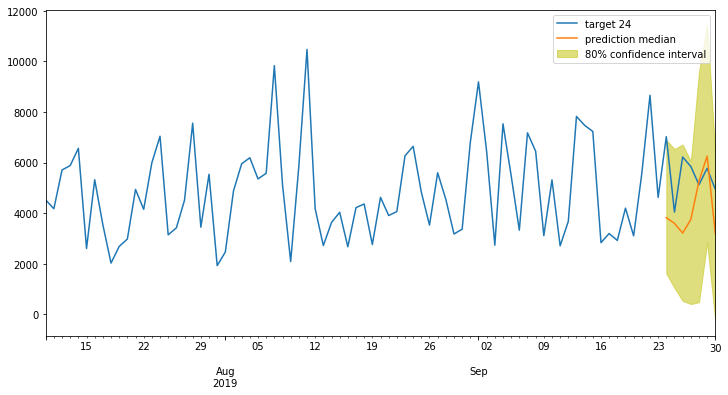

i: 31
RMSE: 1953.2602685560505
MAE: 1640.7100446428426
Target Mean: 9007.67142857143
                 y_pred  y_label
2019-09-24  7585.973633   7383.9
2019-09-25  7406.718262   8558.8
2019-09-26  6347.934570   9763.9
2019-09-27  6370.188477   8243.4
2019-09-28  7543.017090   9221.3
2019-09-29  9853.042969  10352.9
2019-09-30  6866.001953   9529.5


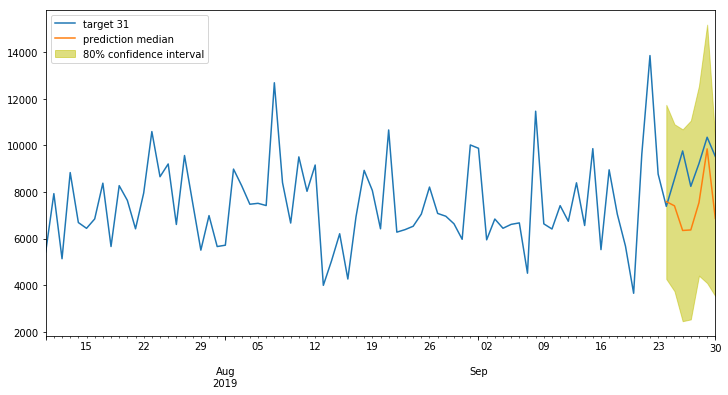

i: 36
RMSE: 6453.442540282589
MAE: 4854.89453125
Target Mean: 18153.442857142858
                  y_pred  y_label
2019-09-24  13278.333984  13646.5
2019-09-25  14162.171875  16744.0
2019-09-26  12649.940430  15419.9
2019-09-27  14251.689453  18162.3
2019-09-28  24446.810547  26111.2
2019-09-29  25642.615234  15189.3
2019-09-30   9564.907227  21800.9


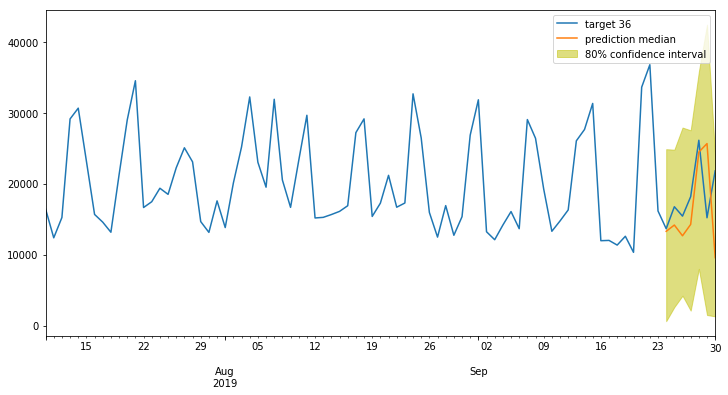

i: 87
RMSE: 10751.30062548166
MAE: 8453.747276785714
Target Mean: 41728.84428571429
                  y_pred   y_label
2019-09-24  37704.683594  34817.70
2019-09-25  40141.972656  33837.11
2019-09-26  41192.039062  32969.10
2019-09-27  45765.074219  36843.10
2019-09-28  68241.835938  67866.62
2019-09-29  62754.808594  39937.69
2019-09-30  36183.453125  45830.59


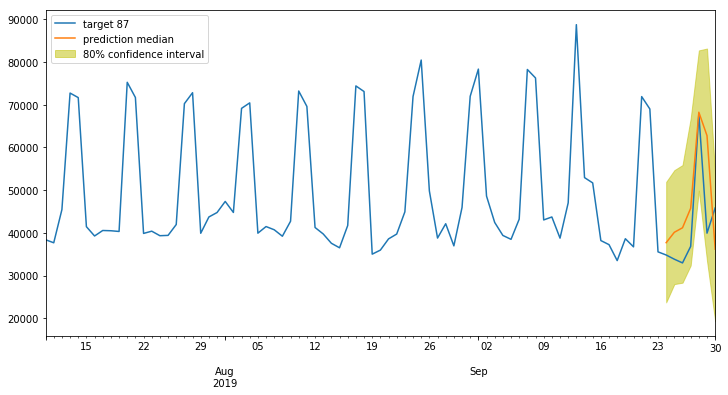

i: 997
RMSE: 1185.3340986627977
MAE: 942.2011662946427
Target Mean: 15377.522857142858
                  y_pred   y_label
2019-09-24  15647.641602  15329.22
2019-09-25  16323.045898  15222.59
2019-09-26  14943.585938  14596.20
2019-09-27  14820.718750  14304.67
2019-09-28  14998.231445  16493.07
2019-09-29  15049.080078  17440.53
2019-09-30  14683.187500  14256.38


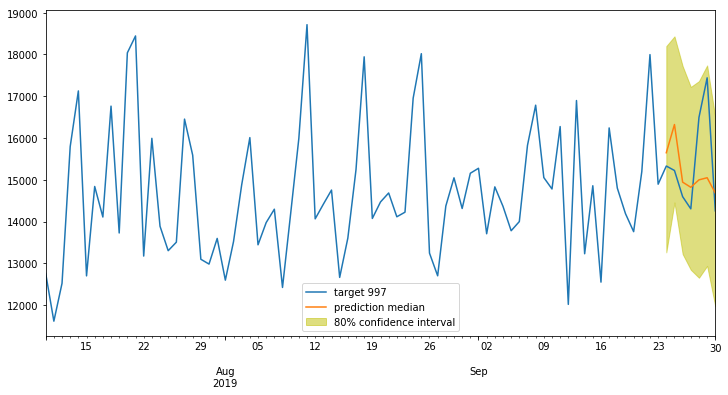

CPU times: user 2.32 s, sys: 36.1 ms, total: 2.36 s
Wall time: 2.35 s


In [51]:
%%time

show_metrics( sample_sites, preds_new, target_quantile='0.5')

### Delete endpoints

In [51]:
predictor.delete_endpoint()

In [52]:
predictor_new_features.delete_endpoint()